<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and statisctic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#### Data Extraction

In [102]:
# set data extraction parameters
start_date = '2017-01-01'
end_date = '2022-06-01'
file_name = '/content/raw_data_etf.csv'
file_name_coint = '/content/raw_data_coint_pairs.csv'
load_existing = True
load_coint_pairs = True

In [103]:
# get new or load existing data
if not load_existing:
  symbols = get_nasdaq_symbols()
  symbols = symbols[(symbols['ETF'] == True) & (symbols['Market Category'] == 'G')] # get Global ETF
  symbols = list(symbols.index.values)
  data = DataReader(name=symbols, data_source='yahoo', start=start_date, end=end_date)['Adj Close']
  data.to_csv(file_name)

In [104]:
data = pd.read_csv(file_name, error_bad_lines=False)
data.dropna(inplace=True, axis=1)
data = data.set_index('Date')
print(f'Shape: {data.shape}')
print(f'Null Values: {data.isnull().values.any()}')
data.head()

Shape: (1363, 265)
Null Values: False


,AADR,AAXJ,ACWI,ACWX,ADRE,AGNG,AGZD,AIA,AIRR,ALTY,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,39.404003,50.324165,53.491852,34.928574,29.558573,14.668802,42.505810,42.452053,23.538317,9.600211,...,96.048004,45.296101,108.774231,51.274086,96.194260,63.629200,40.811722,48.171516,49.646027,25.511465
2017-01-04,40.082230,50.823139,53.949348,35.316765,29.874083,14.668802,42.602840,42.678879,23.885475,9.735156,...,97.151901,45.314533,111.057976,52.043102,97.649651,63.882755,41.262142,48.659973,50.088799,25.843027
2017-01-05,40.512093,51.539852,54.155670,35.618690,30.514109,14.668802,42.594006,43.205097,23.479965,9.807764,...,96.975655,45.369812,110.202805,51.524136,96.333328,64.291672,41.571251,49.131573,50.051899,25.928291
2017-01-06,40.378361,51.285820,54.164646,35.472038,30.081415,14.668802,42.558708,43.023640,23.479965,9.902229,...,97.226128,45.296101,109.639153,51.307114,95.814209,64.111755,41.482937,48.870510,50.051899,25.975655
2017-01-09,40.521645,51.331188,54.039059,35.420284,30.333826,14.668802,42.452873,43.141598,22.985437,9.838611,...,96.892189,45.323746,109.571121,50.962708,94.655472,64.275322,41.403458,48.735756,49.729046,26.039127


### Feature Engineering

In [105]:
# creare data frame returns and volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_returns['volatility'] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,returns,volatility
AADR,0.090635,0.233626
AAXJ,0.086427,0.211931
ACWI,0.115902,0.184653
ACWX,0.078023,0.183579
ADRE,0.089208,0.243986


In [106]:
# scale features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index )
df_scaled = scaled_data
df_scaled.head()

,returns,volatility
AADR,0.014753,0.311722
AAXJ,-0.038123,0.090672
ACWI,0.332246,-0.187269
ACWX,-0.143712,-0.198211
ADRE,-0.003167,0.417291


### K_MEANS Clustering

In [107]:
# find the optimum number of clusters
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"Optimum number of clusters: {c}")

Optimum number of clusters: 5


In [108]:
# fit the KMEANS model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
predict = kmeans.predict(df_scaled)

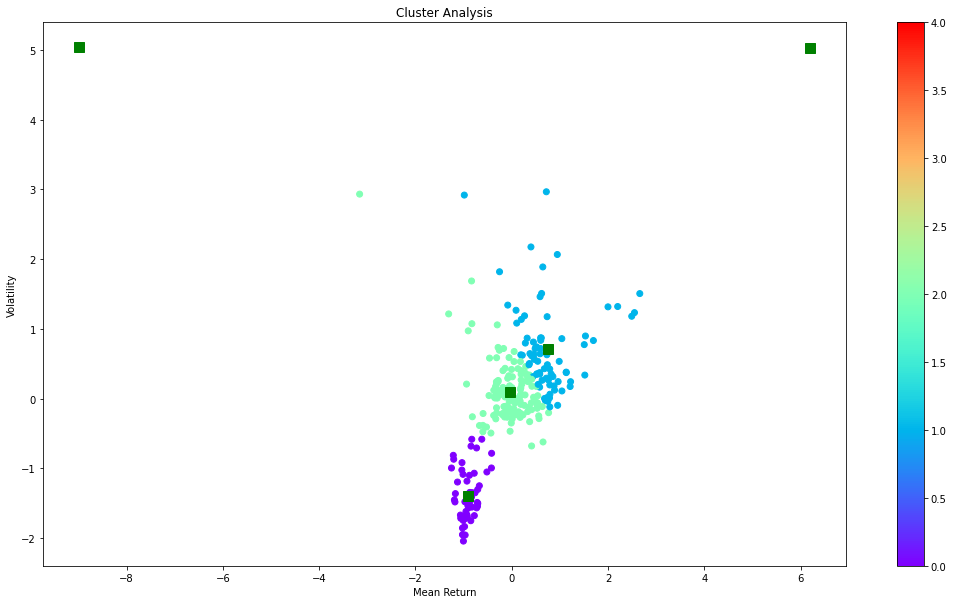

In [109]:
# show results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [110]:
# return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

AADR    2
AAXJ    2
ACWI    2
ACWX    2
ADRE    2
AGNG    2
AGZD    0
dtype: int32

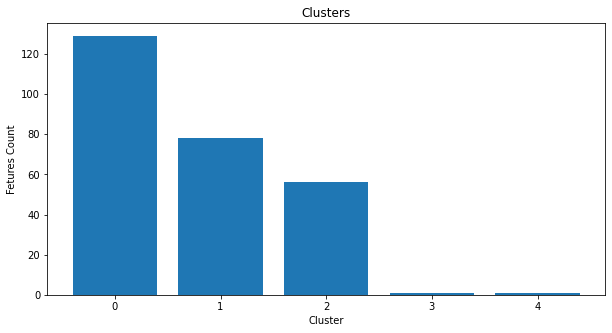

In [111]:
# plot the series
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Fetures Count")
plt.show()

In [112]:
# remove outliers
clustered_series_clean = clustered_series[clustered_series < 3]
print(f"feature number original: {len(clustered_series)}")
print(f"feature number cleaned: {len(clustered_series_clean)}")

feature number original: 265
feature number cleaned: 263


### Calculate Cointegration

In [113]:
def calculate_cointegration(series_1, series_2):
  coint_flag = 0
  coint_res = coint(series_1, series_2)
  coint_t = coint_res[0]
  p_value = coint_res[1]
  critical_value = coint_res[2][1]
  model = simplefilter.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
  return coint_flag, hedge_ratio

In [116]:
# loop through and calculate cointegrated pairs
# allow 10 - 30 min for calculation
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clustered_series_clean.index:
        base_label = clustered_series_clean[base_asset]
        
        for compare_asset in clustered_series_clean.index:
            compare_label = clustered_series_clean[compare_asset]
            
            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset, 
                                               "compare_asset": compare_asset, 
                                               "label": base_label})
                    
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)
    print('saved!')

saved!


In [117]:
# load cointegrated pairs
df_coint = pd.read_csv(file_name_coint).iloc[:,1:]
df_coint.head()

,base_asset,compare_asset,label
0,IUSB,VGSH,0
1,MBB,VGIT,0
2,GNMA,VGIT,0
3,EMCB,VMBS,0
4,IGSB,VGSH,0


### Plotting the result

In [121]:
coint_asset = [df_coint['base_asset'].values]
coint_asset.append(df_coint['compare_asset'].values)
coint_uniqe_asset = np.unique(coint_asset)
coint_uniqe_asset[:5]

array(['AADR', 'AAXJ', 'ACWX', 'ADRE', 'AGNG'], dtype=object)

In [122]:
# get returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_uniqe_asset)]
df_TSNE.head()

,returns,volatility
AADR,0.014753,0.311722
AAXJ,-0.038123,0.090672
ACWX,-0.143712,-0.198211
ADRE,-0.003167,0.417291
AGNG,0.414318,-0.159905


In [125]:
# compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=883, n_jobs=1).fit_transform(df_TSNE)
X_tsne[:5]

array([[-19.567137 ,  -3.7186506],
       [-42.634853 , -10.900544 ],
       [  3.3806543, -40.98363  ],
       [-18.834461 ,  -2.4344099],
       [ 19.438395 , -16.429655 ]], dtype=float32)

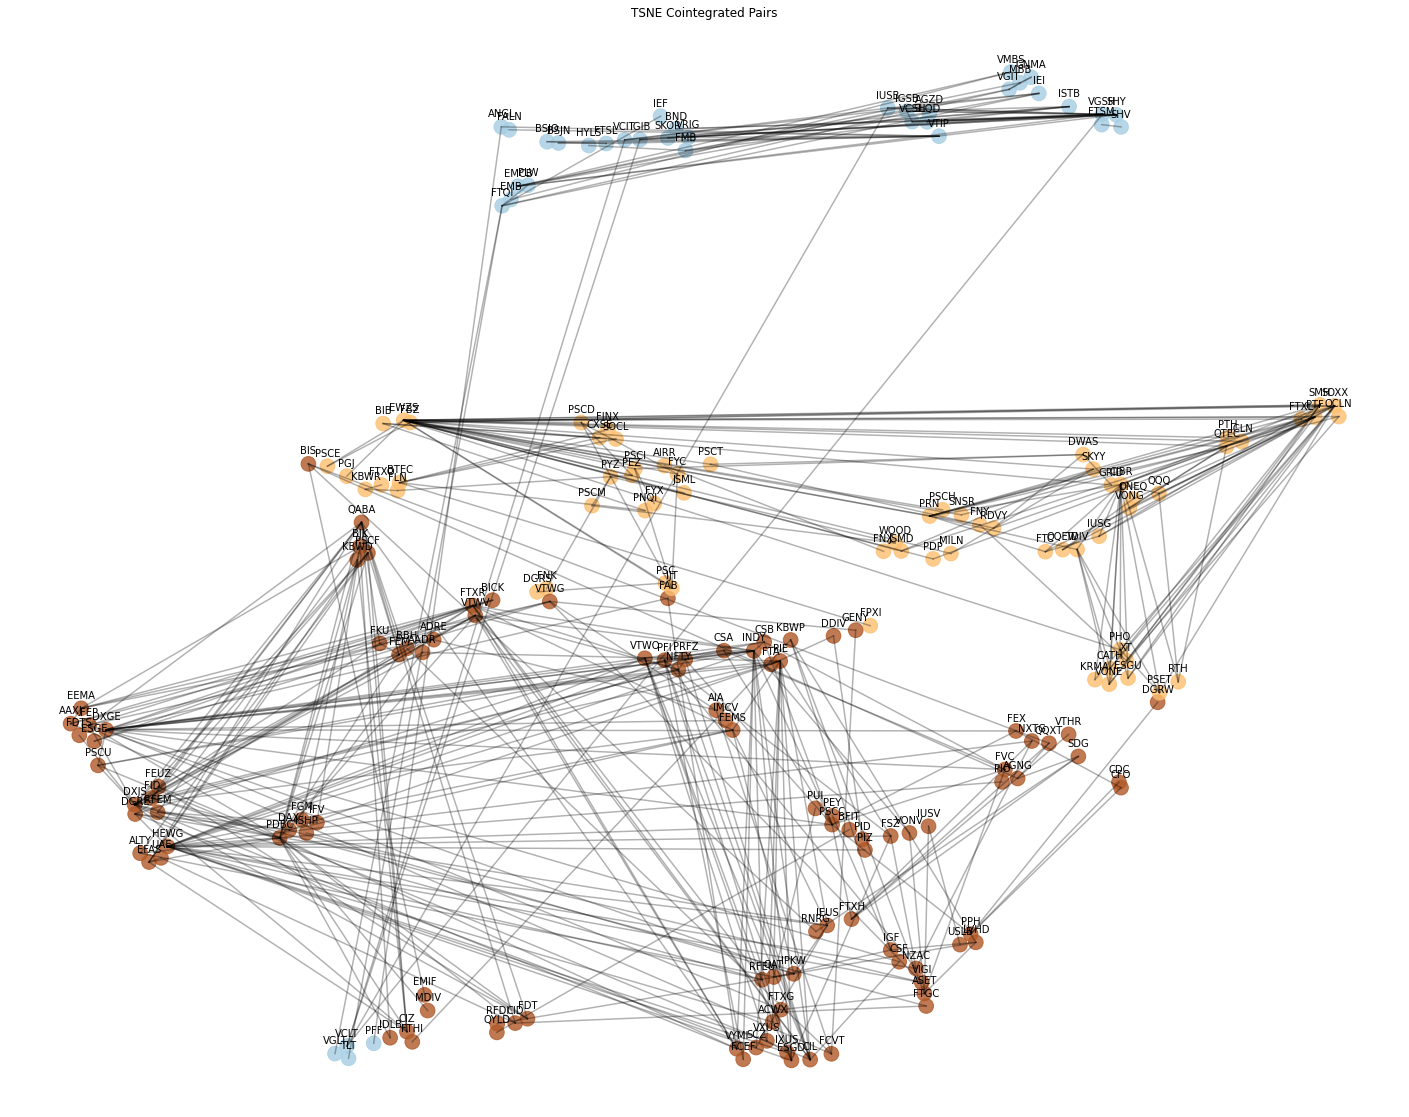

In [126]:
# preview TSNE
in_pairs_series = clustered_series.loc[coint_uniqe_asset]
plt.figure(1, figsize=(25,20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()
